In [32]:
using Gridap, Gridap.Geometry, Gridap.Fields
using Gmsh, GridapGmsh
using GLMakie, DelimitedFiles, Interpolations
using LinearAlgebra, SparseArrays, KrylovKit
using ChainRulesCore, Zygote
using PartitionedArrays
using NLopt
using GridapMakie

import Gridap.CellData: Interpolable
import ChainRulesCore: rrule
import Gmsh: gmsh


main_path = "/Users/jayyao/Documents/Research/RamanInFluid/"
include(main_path*"Materials/Materials.jl")
include(main_path*"Module/Mesh_Periodic.jl")
include(main_path*"Module/Helper.jl")
include(main_path*"Module/GridapFE.jl")
include(main_path*"Module/Control.jl")
include(main_path*"Module/Model.jl")
include(main_path*"Module/Objective.jl")

g0_p_optimize (generic function with 3 methods)

In [113]:
material = "Ag"
n_λ, k_λ = RefractiveIndex(material,main_path,true)
λ1 = 532
λ2 = 549
nf = sqrt(1.77)
nm1 = n_λ(λ1) + 1im * k_λ(λ1)
nm2 = n_λ(λ2) + 1im * k_λ(λ2)
μ = 1
R = 1e-10
nm1,nm2

(0.054007220216606505 + 3.42898916967509im, 0.05988059701492538 + 3.5892477611940294im)

In [114]:
hr = (λ1+λ2)/nf/4          # Height of Raman molecule
# Geometry parameters of the mesh
L = 150           # Length of the normal region
hair = 500 + hr       # Height of the air region
hs = 300 + hr         # Height of the source location in air
ht = 200 + hr         # Height of the target location in air
hd = 200          # Height of design domain
hsub = 100        # Height of substrate domain below design domain
dpml = 300        # Thickness of the PML
hrd = (hd, hr)
# Characteristic length (controls the resolution, smaller the finer)
# resol = 30        # Number of points per wavelength
l1 = 20      # Air
l2 = 1       # Design domain
l3 = l1           # PML

meshfile = "geometry.msh"
geo_param = PeriodicGeometry(L, hair, hs, ht, hd, hsub, dpml, l1, l2, l3)
MeshGenerator(geo_param, meshfile)

LHp=(Inf, hair + hd)  # Start of PML for x,y > 0
LHn=(Inf, hsub)       # Start of PML for x,y < 0


ω1 = 2 * π / λ1
phys1 = PhysicalParameters(ω1, nf, nm1, nm1, μ, R, dpml, LHp, LHn, hd)
ω2 = 2 * π / λ2
phys2 = PhysicalParameters(ω2, nf, nm2, nm2, μ, R, dpml, LHp, LHn, hd)
# run(`scp wyao@txe1-login.mit.edu:/home/gridsan/wyao/Research/RamanInFluid/cloud/task1/geometry.msh /Users/jayyao/Documents/Research/RamanInFluid/`)

Info    : No current model available: creating one
Info    : Clearing all models and views...
Info    : Done clearing all models and views
Info    : Reconstructing periodicity for curve connection 2 - 4
Info    : Reconstructing periodicity for curve connection 5 - 7
Info    : Reconstructing periodicity for curve connection 8 - 10
Info    : Reconstructing periodicity for curve connection 11 - 13
Info    : Reconstructing periodicity for curve connection 14 - 16
Info    : Reconstructing periodicity for curve connection 17 - 19
Info    : Reconstructing periodicity for curve connection 22 - 20
Info    : Meshing 1D...
Info    : Meshing curve 1 (Line)
Info    : Meshing curve 3 (Line)
Info    : Meshing curve 4 (Line)
Info    : Meshing curve 6 (Line)
Info    : Meshing curve 7 (Line)
Info    : Meshing curve 9 (Line)
Info    : Meshing curve 10 (Line)
Info    : Meshing curve 12 (Line)
Info    : Meshing curve 13 (Line)
Info    : Meshing curve 15 (Line)
Info    : Meshing curve 16 (Line)
Info    : Me

PhysicalParameters(0.011444781980290685, 1.3304134695650072, 0.05988059701492538 + 3.5892477611940294im, 0.05988059701492538 + 3.5892477611940294im, 1.0, 1.0e-10, 300.0, (Inf, 903.1323390677645), (Inf, 100.0), 200.0)

In [140]:
############  Optimization parameters #############
flag_f = true       # Turn on filter
flag_t = true       # Turn on threshold

# Filter and threshold paramters
r = (5, 5)  # Filter radius
β = 32.0                  # β∈[1,∞], threshold sharpness
η = 0.5                   # η∈[0,1], threshold center

α = 1.0 / (2 * 1000.0)    # Equivalent loss α = 1/2Q

# Number of subspace
K = 20

# Amplify g for NLopt
Amp = 1e-5

# Sum over kx
nkx = 30
nparts = nkx / 2

Bp = true          # Matrix B depend on parameters?
pv = 1

# Foundary constraint parameters
c = (r[1])^4
lw = r[1]
ls = r[1]
ηe = fηe(lw / r[1])
ηd = fηd(lw / r[1])

control = ControllingParameters(flag_f, flag_t, r, β, η, α, nparts, nkx, K, Amp, Bp, pv, c, ηe, ηd, hrd)

gridap = GridapFE(meshfile, 1, 2, ["DirichletEdges", "DirichletNodes"], ["DesignNodes", "DesignEdges"], ["Target"], ["Source"], flag_f, true)


Info    : Reading 'geometry.msh'...
Info    : 45 entities
Info    : 40355 nodes
Info    : 80382 elements
Info    : Done reading 'geometry.msh'


GridapParameters(UnconstrainedFESpace(), UnconstrainedFESpace(), UnconstrainedFESpace(), UnconstrainedFESpace(), UnconstrainedFESpace(), UnconstrainedFESpace(), 69482, BodyFittedTriangulation(), Measure(), Measure(), Measure(), Measure(), Measure(), Measure(), GenericCellField(), Int8[8, 8, 8, 8, 8, 8, 8, 8, 8, 8  …  10, 10, 10, 10, 10, 10, 10, 10, 10, 10], 7)

In [ ]:
lw = 10
ls = 10
ηe = fηe(lw / r[1])
ηd = fηd(lw / r[1])
c = (r[1])^4
control = ControllingParameters(flag_f, flag_t, r, β, η, α, nparts, nkx, K, Amp, Bp, pv, c, ηe, ηd, hrd)

# p_max = readdlm("p_opt_value.txt", Float64)
pW = p_init#p_max[:]
LWConstraint(pW, []; control, gridap), LSConstraint(pW, []; control, gridap)

g0_p(p_init; kb = 0, phys1, phys2, control, gridap) = 1.5989386871957203e7


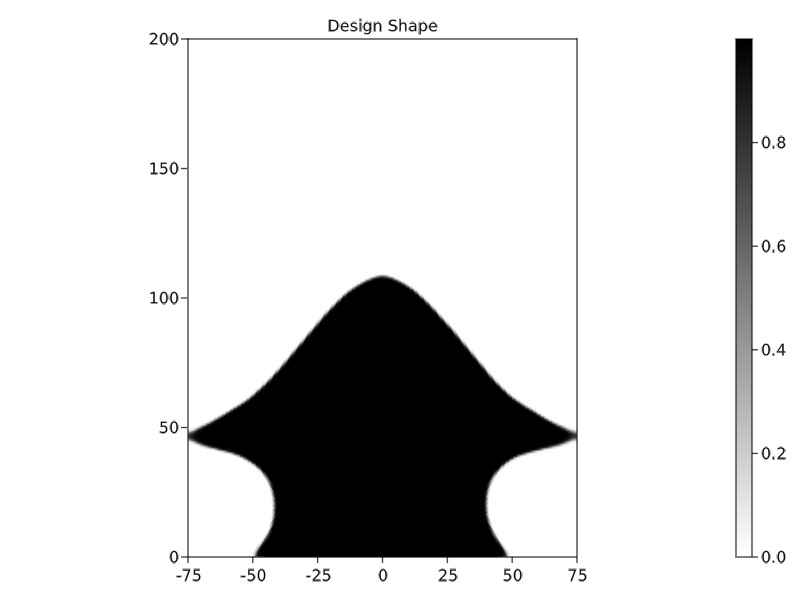

In [146]:
using FileIO
import Images: Gray
# specify the path to your local image file
img_path = "Initial/L150.png"
img = load(img_path)
data = 1.0 .-Float64.(Gray.(img))
function image_to_function(x, data, Lx, Ly)
    Nx, Ny = size(data)
    xi = Nx - Int(round(((x[2]-100)/Lx + 0.5) * Nx))
    yi = Int(round(((x[1])/Ly + 0.5) * Ny))
    if xi > 0 && xi <= Nx && yi > 0 && yi <= Ny
        return data[xi,yi]
    else
        return 0.0
    end
end

binit(v) = ∫(v * x->image_to_function(x, data, 200, 150))gridap.dΩ
pc_vec = assemble_vector(binit, gridap.FE_P)
p_init = p_extract(pc_vec; gridap)
p_init[p_init .< 0.1] .= 0
p_init[p_init .> 0.1] .= 1

#p_init = ones(gridap.np)
pf_vec = pf_p0(p_init; control, gridap)
pfh = FEFunction(gridap.FE_Pf, pf_vec)
pth = (pf -> Threshold(pf; control)) ∘ pfh

@show g0_p(p_init; kb=0, phys1, phys2, control, gridap)
fig, ax, plt = plot(gridap.Ω, pth, colormap = :binary)
Colorbar(fig[1,2], plt)
ax.aspect = AxisAspect(L/(hd))
ax.title = "Design Shape"
limits!(ax, -L/2, L/2, 0, hd)
# save("Results/shape.png", fig)
fig

In [ ]:
function p_bowtie(x, d, h, L, hd)
    dx = abs(x[1]) - d / 2 
    dy = abs(x[2] - hd / 2)
    bowtie = 0
    if dx >= 0 && dy <= h / (L - d) * dx
        bowtie = 1
    end
    return bowtie
end

function p_triangle(x, h, L)
    dx = abs(x[1])
    dy = x[2]
    if dy <= (1-2*dx/L)*h
        return 1
    else
        return 0
    end
end

function p_circle(x, radius)
    if (x[1]^2+(x[2]-radius)^2)<=radius^2
        return 1
    else
        return 0
    end
end

kb = 0
p_trunc(x, ratio) = x[2] < (ratio * hd) ? 1 : 0
binitialfunc(v) = ∫(v * x->p_trunc(x, 0.5))gridap.dΩ
# binitialfunc(v) = ∫(v * x->p_bowtie(x, 20, 80, L, hd))gridap.dΩ
# binitialfunc(v) = ∫(v * x->p_triangle(x, 320, 1.2*L))gridap.dΩ
# binitialfunc(v) = ∫(v * x->p_circle(x, 41))gridap.dΩ
pc_vec = assemble_vector(binitialfunc, gridap.FE_P)
p_init = p_extract(pc_vec; gridap)
p_init[p_init .< 0.1] .= 0
p_init[p_init .> 0.1] .= 1


pf_vec = pf_p0(p_init; control, gridap)
pfh = FEFunction(gridap.FE_Pf, pf_vec)
pth = (pf -> Threshold(pf; control)) ∘ pfh
fig, ax, plt = plot(gridap.Ω, pth, colormap = :binary)
Colorbar(fig[1,2], plt)
ax.aspect = AxisAspect(L/(hd))
ax.title = "Design Shape"
limits!(ax, -L/2, L/2, 0, hd)
@show g0_p(p_init; kb, phys1, phys2, control, gridap)
fig

In [ ]:
g_max = 4.043547777352752e9
g_max/3.304940991544588e7, g_max/209322.53474758018

In [147]:
# p_init = ones(gridap.np) * 0.5 + rand(gridap.np) * 1e-2
β_list = [8.0, 8.0, 16.0, 16.0, 32.0, 32.0, 32.0]
Q_list = [10.0, 50.0, 100.0, 500.0, 1000.0, 1000.0, 1000.0]

g_opt = 0
usat = 1e4
damp = 1e-2
for bi = 1 : 7
    β = β_list[bi]
    α = 1/(2*Q_list[bi])
    if bi < 5
        c = 0
        control = ControllingParameters(flag_f, flag_t, r, β, η, α, nparts, nkx, K, Amp, Bp, pv, c, ηe, ηd, hrd)
    else
        c = (r[1])^4
        control = ControllingParameters(flag_f, flag_t, r, β, η, α, nparts, nkx, K, Amp, Bp, pv, c, ηe, ηd, hrd)
    end

    if bi == 1
        g_opt, p_opt = g0_p_optimize(p_init, 1e-12, 100; phys1, phys2, control, gridap, usat, damp)
    
    else
        g_opt, p_opt = g0_p_optimize([], 1e-12, 100; phys1, phys2, control, gridap, usat, damp)
    end
    if isfile("p_opt.value.txt")
        run(`rm p_opt_value.txt`)
    end
    open("p_opt_value.txt", "w") do iop
        for i = 1 : length(p_opt)
            p_temp = p_opt[i]
            write(iop, "$p_temp \n")
        end
    end
    open("g_opt_value.txt", "a") do io
        write(io, "$g_opt \n")
    end
end
@show g_opt

numevals = opt.numevals = 100
numevals = opt.numevals = 100
numevals = opt.numevals = 100
numevals = opt.numevals = 100
numevals = opt.numevals = 100
numevals = opt.numevals = 100
numevals = opt.numevals = 100
g_opt = 2.172740187997499e7


2.172740187997499e7

g0_p(p0; kb = 0, phys1, phys2, control, gridap) = 2.3679494084121823e7


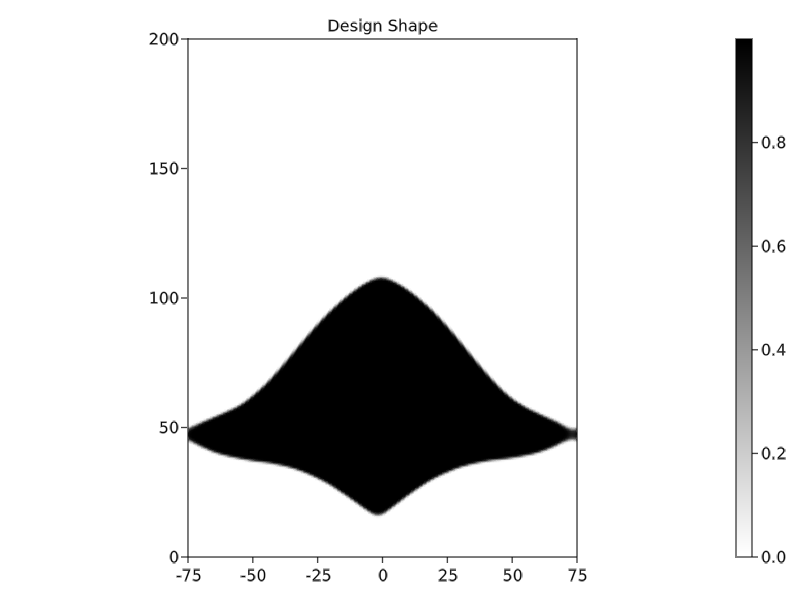

In [148]:
# Output and view
ImportFromFile = true
N = num_free_dofs(gridap.FE_U)
if ImportFromFile
    #p_max = readdlm("cloud/task5/p_opt_value.txt", Float64)
    p_max = readdlm("p_opt_value.txt", Float64)
    p0 = p_max[:]
else
    p0 = zeros(gridap.np)
end

kb = 0
pf_vec = pf_p0(p0; control, gridap)
pfh = FEFunction(gridap.FE_Pf, pf_vec)
pth = (pf -> Threshold(pf; control)) ∘ pfh
A1_mat = MatrixA(pth, kb; phys=phys1, control, gridap)
b1_vec = assemble_vector(v->(∫(v)gridap.dΓ_s), gridap.FE_V)
u1_vec = A1_mat \ b1_vec
u1h = FEFunction(gridap.FE_U, u1_vec)

A2_mat = MatrixA(pth, kb; phys=phys2, control, gridap)
o_vec = VectorO(1, 1; gridap)
v2_vec = A2_mat' \ o_vec
v2h = FEFunction(gridap.FE_U, v2_vec)

@show g0_p(p0; kb=0, phys1, phys2, control, gridap)

fig, ax, plt = plot(gridap.Ω, pth, colormap = :binary)
Colorbar(fig[1,2], plt)
ax.aspect = AxisAspect(L/(hd))
ax.title = "Design Shape"
limits!(ax, -L/2, L/2, 0, hd)
save("Results/shape.png", fig)
fig

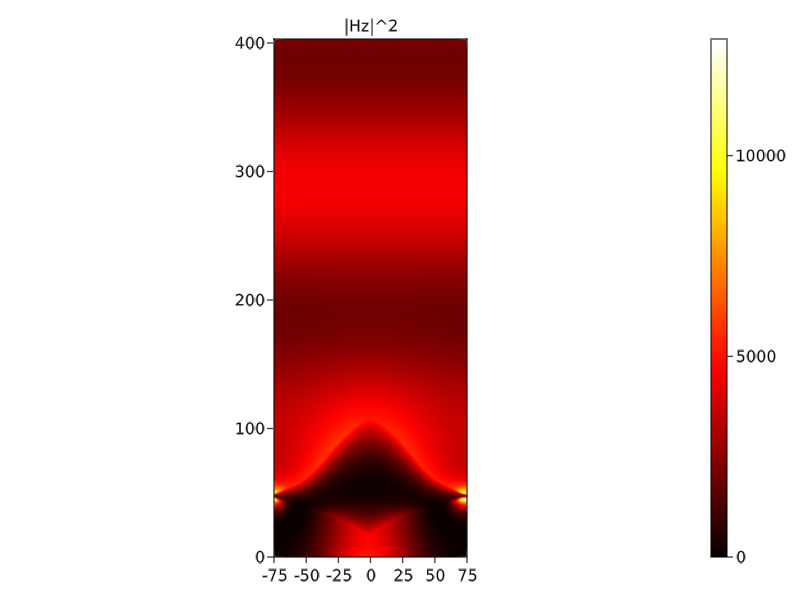

In [150]:
maxv = maximum(abs.(u1_vec))/1
#fig, ax, plt = plot(gridap.Ω, real(u1h), colormap = :bwr, colorrange=(-maxv, maxv))
fig, ax, plt = plot(gridap.Ω, abs2(u1h), colormap = :hot, colorrange=(0, maxv^2))
Colorbar(fig[1,2], plt)
ax.title = "|Hz|^2"
#ax.aspect = AxisAspect(L/(phys1.LHp[2]+phys1.LHn[2]))
#limits!(ax, -L/2, L/2, -phys1.LHn[2], phys1.LHp[2])
ax.aspect = AxisAspect(L/(hd+hr*1))
limits!(ax, -L/2, L/2, 0, hd+hr*1)
save("Results/Field_opt.png", fig)
fig

In [ ]:
Nwave = 100
raman_shift = 17
gwave = zeros(Nwave)
λ1_list = zeros(Nwave)

p_max = readdlm("p_opt_value.txt", Float64)
p_cur = p_max[:]

for li = 1:Nwave
    λ1 = 532 +(li-25) * 5
    λ1_list[li] = λ1
    λ2 = λ1 + raman_shift
    nm1 = n_λ(λ1) + 1im * k_λ(λ1)
    nm2 = n_λ(λ2) + 1im * k_λ(λ2)
    ω1 = 2 * π / λ1
    phys1 = PhysicalParameters(ω1, nf, nm1, nm1, μ, R, dpml, LHp, LHn, hd)
    ω2 = 2 * π / λ2
    phys2 = PhysicalParameters(ω2, nf, nm2, nm2, μ, R, dpml, LHp, LHn, hd)
    gwave[li] = g0_p(p_cur, []; kb=0, phys1, phys2, control, gridap)/control.Amp
end

scene, layout = layoutscene(resolution=(1400,900))
ax = layout[1,1]=Axis(scene)

lin1=lines!(ax,λ1_list, gwave[:])
# grad = zeros(gridap.np)
# g0_p(p0, grad; kb, phys1, phys2, control, gridap)
#ax.yscale = log10
ax.xlabel="λ"
ax.ylabel="Power"
#ax.title="Eigenvalue distribution"

# Legend(layout[1,1],[lin1, lin2],["Initial", "Optimized"])
# axislegend(ax, [lin1, lin2, lin3],["All","Far field","Difference"], position = :lt,
#     orientation = :vertical)
# save("Results/EigenValDistributionIO.png",scene)
scene

In [74]:
# gvalues = readdlm("gvalue.txt", Float64)
# gavlues = gvalues[:]
include(main_path*"Module/Model.jl")
include(main_path*"Module/Objective.jl")

g0_p_optimize (generic function with 3 methods)

In [88]:
p0 = rand(gridap.np)
δp = rand(gridap.np)*1e-8
grad = zeros(gridap.np)

kb = 0.0 * ω1
usat = 1e4
damp = 1e-2
# g0 = g0_p(p0, grad; kb, phys1, phys2, control, gridap)
# g1 = g0_p(p0+δp,[]; kb, phys1, phys2, control, gridap)
g0 = g0_p(p0, grad; kb, phys1, phys2, control, gridap,usat,damp)
g1 = g0_p(p0+δp,[]; kb, phys1, phys2, control, gridap,usat,damp)
g1-g0, grad'*δp
#1.609129978462141e8

(1.0759496960055515e-7, 1.0759501443279249e-7)

In [130]:
usat = 1e4
damp = 1e-2
g0_p(p_init; kb=0, phys1, phys2, control, gridap, usat, damp)

2.520697234554637e6

In [ ]:
gmax = 0
rmax = 0
for radius = 1:75
    binitialfunc(v) = ∫(v * x->p_circle(x, radius))gridap.dΩ
    pc_vec = assemble_vector(binitialfunc, gridap.FE_P)
    p_init = p_extract(pc_vec; gridap)
    p_init[p_init .< 0.1] .= 0
    p_init[p_init .> 0.1] .= 1
    @show gtemp = g0_p(p_init, []; kb=0, phys1, phys2, control, gridap)
    if gtemp > gmax
        gmax = gtemp
        rmax = radius
    end
end
gmax, rmax

In [ ]:
gmax = 0
dmax = 0
hmax = 0
for d = 10:10:150
    for h = 10:10:200
        bowtie_temp(v) = ∫(v * x->p_bowtie(x, d, h, L, hd))gridap.dΩ
        pc_vec = assemble_vector(bowtie_temp, gridap.FE_P)
        p0 = p_extract(pc_vec; gridap)
        @show gtemp = g0_p(p0, []; kb=0, phys1, phys2, control, gridap)
        if gtemp > gmax
            gmax = gtemp
            dmax = d
            hmax = h
        end
    end
end
gmax, dmax, hmax

In [ ]:
function g_hr(hr)
    # Geometry parameters of the mesh
    L = 150           # Length of the normal region
    hair = 500 + hr       # Height of the air region
    hs = 300 + hr         # Height of the source location in air
    ht = 200 + hr         # Height of the target location in air
    hd = 200          # Height of design domain
    hsub = 100        # Height of substrate domain below design domain
    dpml = 300        # Thickness of the PML
    hrd = [hd, hr]
    # Characteristic length (controls the resolution, smaller the finer)
    resol = 30        # Number of points per wavelength
    l1 = L/resol      # Air
    l2 = l1/10.0       # Design domain
    l3 = l1           # PML

    meshfile = "geometry.msh"
    geo_param = PeriodicGeometry(L, hair, hs, ht, hd, hsub, dpml, l1, l2, l3)
    MeshGenerator(geo_param, meshfile)

    ############  Optimization parameters #############
    flag_f = true       # Turn on filter
    flag_t = true       # Turn on threshold

    # Filter and threshold paramters
    r = [0.02 * L, 0.02 * L]  # Filter radius
    β = 80.0                  # β∈[1,∞], threshold sharpness
    η = 0.5                   # η∈[0,1], threshold center

    α = 0.0 / (2 * 1000.0)    # Equivalent loss α = 1/2Q

    # Number of subspace
    K = 20

    # Amplify g for NLopt
    Amp = 1

    # Sum over kx
    nkx = 30
    nparts = nkx / 2

    Bp = true          # Matrix B depend on parameters?
    pv = 1
    kb = 0
    
    # Foundary constraint parameters
    c = 0#resol^4
    lw = r[1]
    ls = r[1]
    ηe = fηe(lw / r[1])
    ηd = fηd(lw / r[1])

    control = ControllingParameters(flag_f, flag_t, r, β, η, α, nparts, nkx, K, Amp, Bp, pv, c, ηe, ηd, hrd)

    gridap = GridapFE(meshfile, 1, 2, ["DirichletEdges", "DirichletNodes"], ["DesignNodes", "DesignEdges"], ["Target"], ["Source"], flag_f, true)
    
    material = "Silver"
    n_λ, k_λ = RefractiveIndex(material,main_path)
    λ1 = 549
    λ2 = 549
    nm1 = n_λ(λ1) + 1im * k_λ(λ1)
    nm2 = n_λ(λ2) + 1im * k_λ(λ2)
    nm1 = imag(nm1)
    nm2 = imag(nm2)
    nf = sqrt(1.77)
    μ = 1
    R = 1e-10
    LHp=[Inf, hair + hd]  # Start of PML for x,y > 0
    LHn=[Inf, hsub]       # Start of PML for x,y < 0


    ω1 = 2 * π / λ1
    phys1 = PhysicalParameters(ω1, nf, nm1, nm1, μ, R, dpml, LHp, LHn, hd)
    ω2 = 2 * π / λ2
    phys2 = PhysicalParameters(ω2, nf, nm2, nm2, μ, R, dpml, LHp, LHn, hd)

    d = 20
    h = 80
    bowtie_temp(v) = ∫(v * x->p_bowtie(x, d, h, L, hd))gridap.dΩ
    pc_vec = assemble_vector(bowtie_temp, gridap.FE_P)
    pbowtie = p_extract(pc_vec; gridap)
    p_init = pbowtie#rand(gridap.np)

    pf_vec = pf_p0(p_init; control, gridap)
    pfh = FEFunction(gridap.FE_Pf, pf_vec)
    pth = (pf -> Threshold(pf; control)) ∘ pfh
    A1_mat = MatrixA(pth, kb; phys=phys1, control, gridap)
    b1_vec = assemble_vector(v->(∫(v)gridap.dΓ_s), gridap.FE_V)
    u1_vec = A1_mat\b1_vec
    u1h = FEFunction(gridap.FE_U, u1_vec)
#     O_mat = MatrixOl(phys1.ω, phys1.nf^2; gridap)
#     o_vec = VectorO(1, 1; gridap)
    
#     planewave(v) = ∫(v * x->exp(1im*phys1.ω*nf^2*x[2]))gridap.dΩ
#     b_plane = assemble_vector(planewave, gridap.FE_U)

#     AE_mat = assemble_matrix(gridap.FE_U, gridap.FE_V) do u, v
#             ∫(u*v)gridap.dΩ 
#     end
#    uh_plane = FEFunction(gridap.FE_U, AE_mat\b_plane)
    
    B_mat = MatrixB(pth, u1h; control, gridap)
    B0_mat = MatrixB0(pth, λ2/nf/2, u1h; control, gridap)
    #B1_mat = MatrixB0(pth, 1.5*λ2/nf, u1h; control, gridap)
    
    A2_mat = MatrixA(pth, kb; phys=phys2, control, gridap)
    o_vec = VectorO(1, 1; gridap)
    v2_vec = A2_mat'\o_vec
    gp = real(v2_vec' * B_mat * v2_vec)
    g0 = real(v2_vec' * B0_mat * v2_vec)
    # g1 = real(v2_vec' * B1_mat * v2_vec)
    return gp, g0
    # return sum(∫(abs(u1h))gridap.dΓ_t), real(u1_vec'*O_mat*u1_vec)
end

In [ ]:
Ng = 40
g_list = zeros(Ng)
g0_list = zeros(Ng)
g1_list = zeros(Ng)
h_list = zeros(Ng)

for hi = 1:Ng
    print(hi,"\n")
    λ2 = 549/sqrt(1.77)
    hr = (hi+0) * λ2 / 2
    h_list[hi] = hr/λ2
    gp, g0= g_hr(hr)
    # gp, g0, g1= g_hr(hr)
    g_list[hi] = gp
    g0_list[hi] = g0
    # g1_list[hi] = g1
    # g_list[hi] = g_hr_fixmesh(pth, hr; phys1, phys2, control, gridap)
end

In [ ]:
scene, layout = layoutscene(resolution=(1400,900))
ax = layout[1,1]=Axis(scene)
ms = 10
# lin1 = GLMakie.scatter!(ax,h_list,g_list)
# #lin2 = lines!(ax,h_list,g0_list)
# lin2 = GLMakie.scatter!(ax,h_list,range(1,length(h_list),step=1).*g0_list)
lin3 = GLMakie.scatter!(ax,h_list,g_list-range(1,length(h_list),step=1).*g0_list)

#lin2 = scatter!(ax,range(1,12,step=1),g_r10,markersize=10)
#lin3 = lines!(ax,range(1,12,step=1),gr_r5.+1e-9)
#ax.yscale = log10
ax.xlabel="hr/λ"
ax.ylabel="Power"
#ax.title="Eigenvalue distribution"

# Legend(layout[1,1],[lin1, lin2],["Initial", "Optimized"])
# axislegend(ax, [lin1, lin2, lin3],["All","Far field","Difference"], position = :lt,
#     orientation = :vertical)
# save("Results/EigenValDistributionIO.png",scene)
scene

In [ ]:
open("Bowtie.txt", "w") do iop
    for i = 1 : length(h_list)
        h_temp = h_list[i]
        g_temp = g_list[i]
        write(iop, "$h_temp $g_temp \n")
    end
end

In [ ]:
gh0 = readdlm("FlatSurface.txt")
ghp = readdlm("Bowtie.txt")
h0_list = gh0[:,1]
g0_list = gh0[:,2]
gp_list = ghp[:,2]
GLMakie.lines(h0_list, gp_list-g0_list)

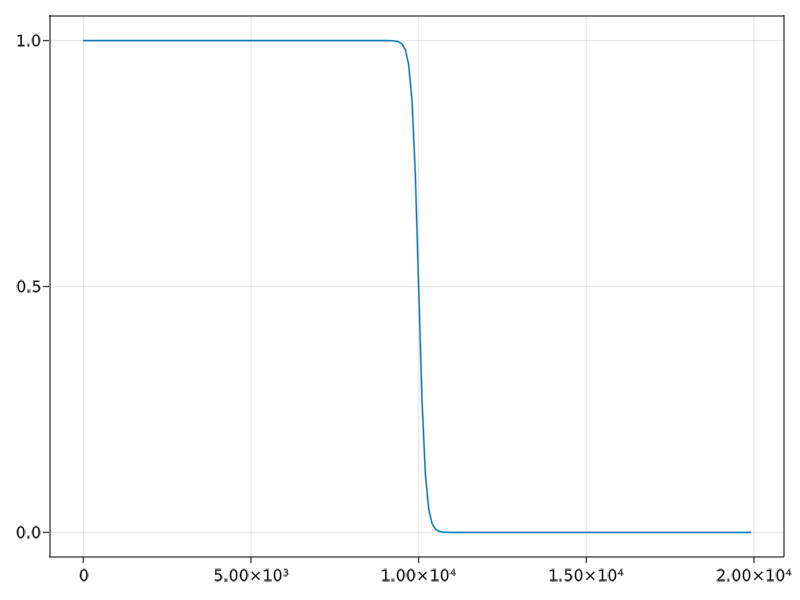

In [85]:
sat_test(x, sat, damp) = 1 ./ (1 .+ exp.(damp*(x.-sat)))
xx = range(1,2e4,step=1e2)
lines(xx, sat_test(xx, 1e4, 1e-2))